In [1]:
import os
import pickle
import random
import editdistance
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.client import device_lib
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from matplotlib import font_manager
from crnn_model_v1 import CRNN
from crnn_data_v1 import InputGenerator, modified_gen
from crnn_utils_v1 import decode
from utils.gt_util import GTUtility

In [2]:
devices = device_lib.list_local_devices()
device_types = [device.device_type for device in devices]

if 'GPU' in device_types:
    print("Current device type:           GPU")
else:
    print("Current device type:           CPU")

current_directory = os.getcwd()
os.chdir(current_directory)
print(f"Current working directory:    ", os.getcwd())

font_path = 'fonts/NanumBarunGothic.ttf'
font_prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['font.size'] = 12
plt.rcParams['font.sans-serif'] = ['NanumBarunGothic']

print("Current font name:            ", plt.rcParams['font.family'])

Current device type:           GPU
Current working directory:     c:\Users\pja36\OneDrive\Desktop\Project\Model.v2
Current font name:             ['NanumBarunGothic']


In [3]:
base_path = 'data/text_in_the_wild_data/'
model_path = 'models/'
model_name = 'model_weights_v12.h5'
from models.hyper_param_v12 import (ocr_dict, leaky, fctc, drop, batch_size, input_shape, max_string_len, 
                        lr, decay, momentum, clipnorm, epoch, freeze, opt)

print(f"Model Name: {model_name.upper()}")
print("---------------------------------")
print("Model Type: CRNN")
print("Model Param:")
print(f"    epoch:            {epoch}")
print(f"    batch_size:       {batch_size}")
print(f"    leaky ReLU:       {leaky}")
print(f"    focal CTC:        {fctc}")
print(f"    dropout:          {drop}")
print(f"    freeze:           {freeze if freeze else 'None'}")
print("---------------------------------")
print(f"Optimizer: {opt}")
print("Optimizer Param:")
print(f"    learning rate:    {lr}")
print(f"    decay:            {decay}")
print(f"    momentum(SGD):    {momentum}")
print(f"    clipnorm:         {clipnorm}")

Model Name: MODEL_WEIGHTS_V12.H5
---------------------------------
Model Type: CRNN
Model Param:
    epoch:            300
    batch_size:       128
    leaky ReLU:       0.1
    focal CTC:        (0.25, 0.75)
    dropout:          None
    freeze:           None
---------------------------------
Optimizer: Adam
Optimizer Param:
    learning rate:    0.001
    decay:            0.001
    momentum(SGD):    0.9
    clipnorm:         1.0


In [4]:
batch_size = 1024
with open(base_path + 'gt_test_util_text.pkl', 'rb') as f:
    gt_test_util = pickle.load(f)
gen_test = InputGenerator(gt_test_util, batch_size, ocr_dict, input_shape[:2], 
                        grayscale=True, max_string_len=max_string_len, concatenate=False, fctc=fctc)
print("Total number of test data samples:  ", gen_test.num_samples)

Total number of test data samples:   8000


In [5]:
model, model_pred = CRNN(input_shape, len(ocr_dict), leaky=leaky, fctc=fctc, drop=drop, gru=False)
model.load_weights(model_path + model_name)

if opt == 'Adam': 
        optimizer = Adam(learning_rate=lr, decay=decay, clipnorm=clipnorm)
else: optimizer = SGD(learning_rate=lr, decay=decay, clipnorm=clipnorm, momentum=momentum, nesterov=True)

for layer in model.layers:
        layer.trainable = not layer.name in freeze

key = 'focal_ctc' if fctc else 'ctc'
model.compile(loss={key: lambda y_true, y_pred: y_pred}, optimizer=optimizer, metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 256, 32, 1)] 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 256, 32, 64)  640         image_input[0][0]                
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 128, 16, 64)  0           conv1_1[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 128, 16, 128) 73856       pool1[0][0]                      
____________________________________________________________________________________________

In [6]:
print("Evaluate on Test Set")
test_loss, test_accuracy = model.evaluate(modified_gen(gen_test.generate(), fctc), 
                            steps=gt_test_util.num_objects // (2*batch_size),
                            batch_size=2*batch_size)

print(f"Test loss:       {test_loss:.4f}")
print(f"Test accuracy:   {test_accuracy:.4f}")

Evaluate on Test Set
67/67 [==============================] - 137s 2s/step - loss: 0.3019 - accuracy: 0.8877
Test loss:       0.3019
Test accuracy:   0.8877


In [7]:
data = next(gen_test.generate(train=False))
pred_data = model_pred.predict(data[0]['image_input'])
total_images = len(data[0]['image_input'])

In [8]:
mean_ed = 0
mean_ed_norm = 0
correct_predictions = 0
total_accuracy = 0

precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

for i in range(len(pred_data)):
    chars = [ocr_dict[c] for c in np.argmax(pred_data[i], axis=1)]
    gt_str = data[0]['source_str'][i]
    pred_str = decode(chars)
    ed = editdistance.eval(gt_str, pred_str)
    ed_norm = ed / len(gt_str)
    mean_ed += ed
    mean_ed_norm += ed_norm
    
    if gt_str == pred_str:
        correct_predictions += 1

    correct_chars = sum(1 for a,b in zip(gt_str, pred_str) if a == b)
    accuracy = correct_chars / len(gt_str)
    total_accuracy += accuracy

    max_len = max(len(gt_str), len(pred_str))
    padded_gt_str = gt_str[:max_len].ljust(max_len, '_')
    padded_pred_str = pred_str[:max_len].ljust(max_len, '_')

    precision = precision_score(list(padded_gt_str), list(padded_pred_str), average='weighted', zero_division=0)
    precision_scores.append(precision)
    
    recall = recall_score(list(padded_gt_str), list(padded_pred_str), average='weighted', zero_division=0)
    recall_scores.append(recall)
    
    f1 = f1_score(list(padded_gt_str), list(padded_pred_str), average='weighted')
    f1_scores.append(f1)
    
    accuracy = accuracy_score(list(padded_gt_str), list(padded_pred_str))
    accuracy_scores.append(accuracy)

In [9]:
def show_test_result(indices):
    for i in indices:
        chars = [ocr_dict[c] for c in np.argmax(pred_data[i], axis=1)]
        gt_str = data[0]['source_str'][i]
        pred_str = decode(chars)
        
        ed = editdistance.eval(gt_str, pred_str)
        ed_norm = ed / len(gt_str)

        max_len = max(len(gt_str), len(pred_str))
        padded_gt_str = gt_str[:max_len].ljust(max_len, '_')
        padded_pred_str = pred_str[:max_len].ljust(max_len, '_')

        precision = precision_score(list(padded_gt_str), list(padded_pred_str), average='weighted', zero_division=0)  
        recall = recall_score(list(padded_gt_str), list(padded_pred_str), average='weighted', zero_division=0)    
        f1 = f1_score(list(padded_gt_str), list(padded_pred_str), average='weighted')    
        accuracy = accuracy_score(list(padded_gt_str), list(padded_pred_str))

        img = data[0]['image_input'][i][:,:,0].T
        plt.figure(figsize=[10, 1])
        plt.imshow(img, cmap='gray', interpolation=None)
        ax = plt.gca()
        plt.text(0, 50, '%s' % (''.join(chars)) )
        plt.text(0, 60, 'GT: %-24s RT: %-24s' % (gt_str, pred_str))
        plt.text(0, 70, 'Editdistance: %0.2f' % ed_norm)
        plt.text(0, 80, 'Precision: %0.2f   Recall: %0.2f   F1 score: %0.2f   Accuracy: %0.2f' % (precision, recall, f1, accuracy))
        plt.show()

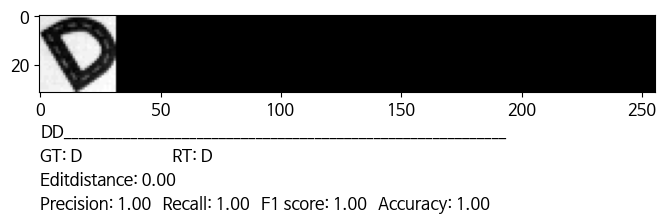

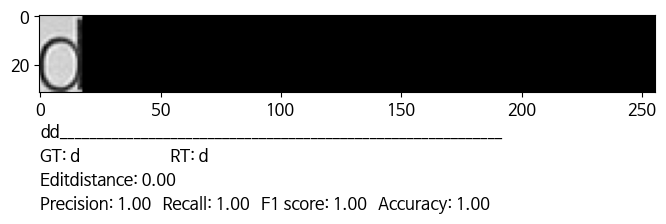

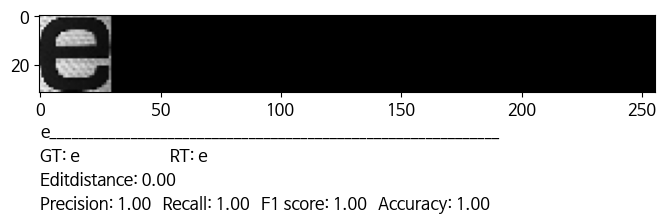

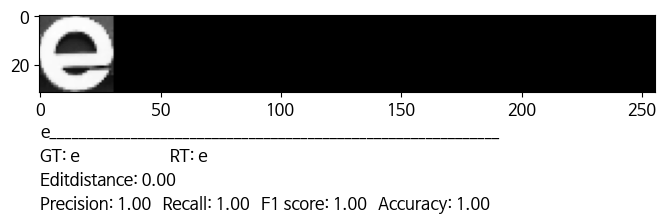

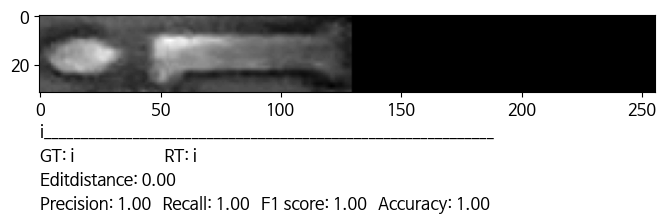

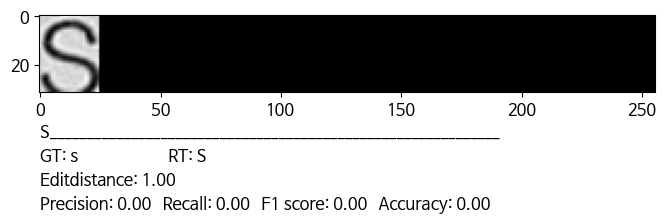

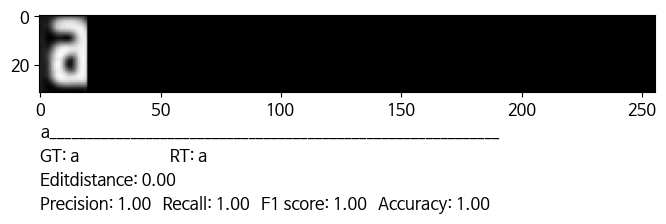

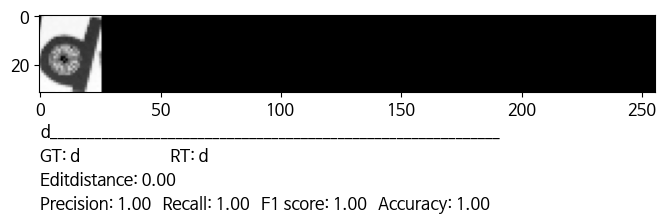

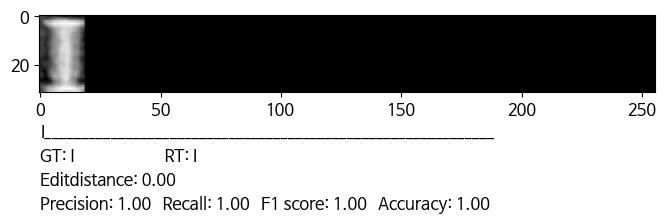

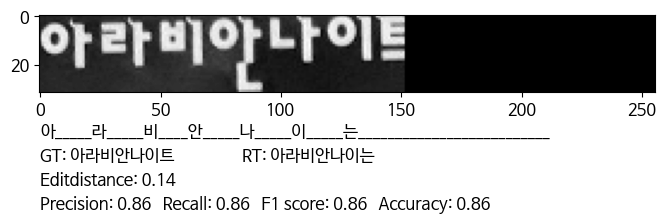

In [10]:
n_show = 10
total_images = len(data[0]['image_input'])
random_indices = random.sample(range(total_images), n_show)
show_test_result(random_indices)

In [11]:
print(f"\nMean Editdistance:                  {mean_ed/total_images:.4f}")
print(f"Mean Normalized Editdistance:       {mean_ed_norm/total_images:.4f}")

print(f"\nMatching Ratio:                     {correct_predictions/total_images:.4f}")
print(f"Average Accuracy per Image:         {total_accuracy/total_images:.4f}")

def list_avg(list):
    avg = sum(list)/len(list)
    return avg

print(f"\nAverage Precision:                  {list_avg(precision_scores):.4f}")
print(f"Average Recall:                     {list_avg(recall_scores):.4f}")
print(f"Average F1 Score:                   {list_avg(f1_scores):.4f}")
print(f"Average Accuracy:                   {list_avg(accuracy_scores):.4f}")

filtered_precision_scores = [score for score in precision_scores if score != 0]
filtered_recall_scores = [score for score in recall_scores if score != 0]
filtered_f1_scores = [score for score in f1_scores if score != 0]
filtered_accuracy_scores = [score for score in accuracy_scores if score != 0]

print(f"\nAverage Filtered Precision:         {list_avg(filtered_precision_scores):.4f}")
print(f"Average Filtered Recall:            {list_avg(filtered_recall_scores):.4f}")
print(f"Average Filtered F1 Score:          {list_avg(filtered_f1_scores):.4f}")
print(f"Average Filtered Accuracy:          {list_avg(filtered_accuracy_scores):.4f}")


Mean Editdistance:                  0.2881
Mean Normalized Editdistance:       0.1477

Matching Ratio:                     0.8242
Average Accuracy per Image:         0.8543

Average Precision:                  0.8541
Average Recall:                     0.8537
Average F1 Score:                   0.8538
Average Accuracy:                   0.8537

Average Filtered Precision:         0.9783
Average Filtered Recall:            0.9778
Average Filtered F1 Score:          0.9779
Average Filtered Accuracy:          0.9778


precision score list:     [1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8, 0.0, 0.875, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.25, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.5714285714285714, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

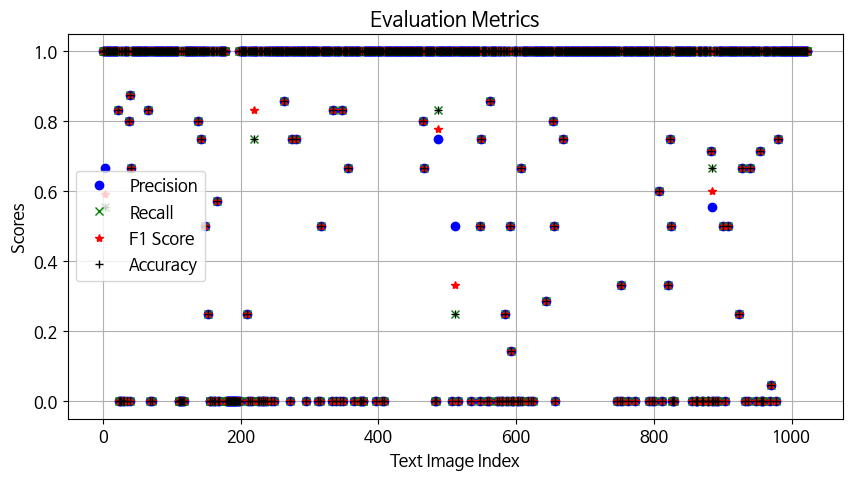

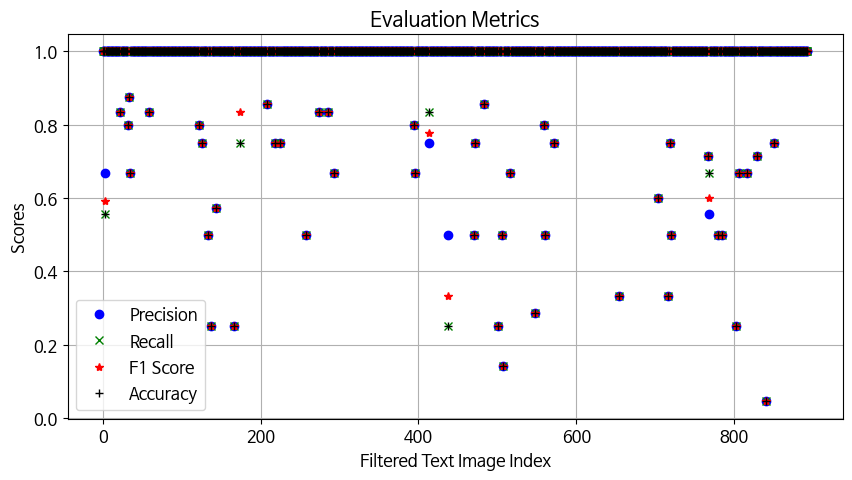

In [12]:
print('precision score list:    ', precision_scores)
print('recall score list:       ', recall_scores)
print('f1 score list:           ', f1_scores)
print('accuracy score list:     ', accuracy_scores)

plt.figure(figsize=(10, 5))
plt.plot(precision_scores, label='Precision', marker='o', linestyle='', color='blue')
plt.plot(recall_scores, label='Recall', marker='x', linestyle='', color='green')
plt.plot(f1_scores, label='F1 Score', marker='*', linestyle='', color='red')
plt.plot(accuracy_scores, label='Accuracy', marker='+', linestyle='', color='black')

plt.xlabel('Text Image Index')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)

plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_precision_scores, label='Precision', marker='o', linestyle='', color='blue')
plt.plot(filtered_recall_scores, label='Recall', marker='x', linestyle='', color='green')
plt.plot(filtered_f1_scores, label='F1 Score', marker='*', linestyle='', color='red')
plt.plot(filtered_accuracy_scores, label='Accuracy', marker='+', linestyle='', color='black')

plt.xlabel('Filtered Text Image Index')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')
plt.legend()
plt.grid(True)

plt.show()

In [13]:
indices = []
zero_indices = []
dlist = precision_scores
for index, value in enumerate(dlist):
    if value != 1:
        if value == 0:
            zero_indices.append(index)
        else:
            indices.append(index)


print("Indices of which data has non-one value:      ", indices)
print("Indices of which data has zero value:         ", zero_indices)

Indices of which data has non-one value:       [3, 22, 38, 40, 41, 66, 138, 142, 149, 153, 165, 209, 263, 274, 280, 317, 334, 347, 356, 465, 466, 486, 512, 548, 549, 562, 584, 591, 593, 607, 643, 654, 655, 668, 752, 807, 821, 824, 825, 883, 885, 901, 907, 924, 928, 940, 954, 970, 980]
Indices of which data has zero value:          [24, 25, 26, 29, 31, 35, 39, 68, 72, 110, 111, 112, 113, 115, 117, 118, 155, 156, 159, 162, 163, 167, 168, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 210, 214, 217, 225, 226, 229, 232, 233, 236, 239, 244, 248, 272, 295, 312, 315, 332, 339, 345, 349, 365, 373, 375, 377, 378, 396, 405, 408, 482, 483, 507, 515, 535, 547, 558, 560, 572, 575, 579, 580, 586, 588, 592, 595, 596, 602, 603, 606, 609, 618, 621, 625, 656, 746, 751, 754, 763, 773, 793, 797, 800, 812, 826, 828, 829, 855, 861, 862, 863, 870, 872, 878, 879, 884, 886, 889, 892, 893, 904, 932, 936, 949, 956, 957, 959, 968, 977]


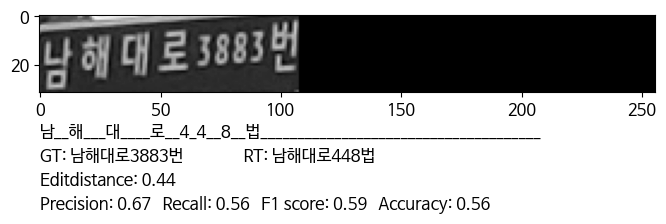

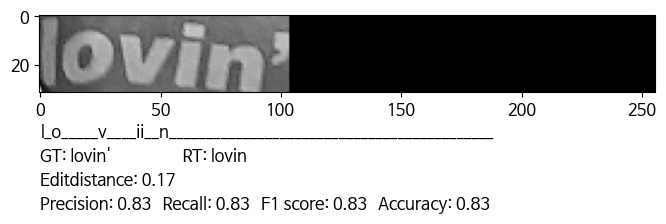

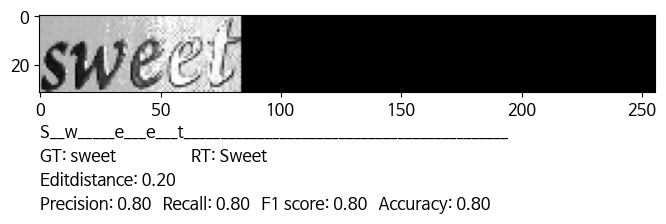

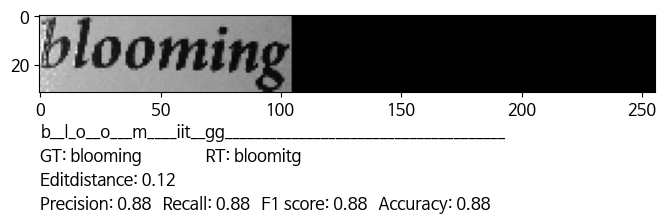

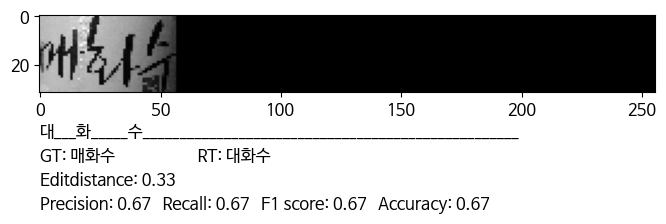

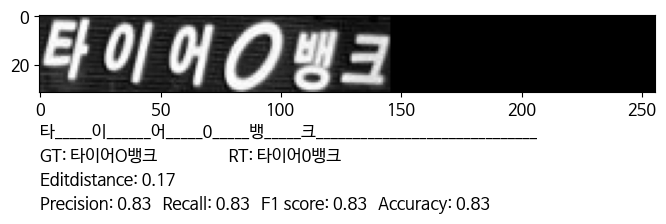

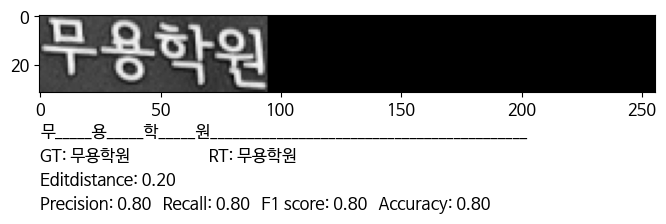

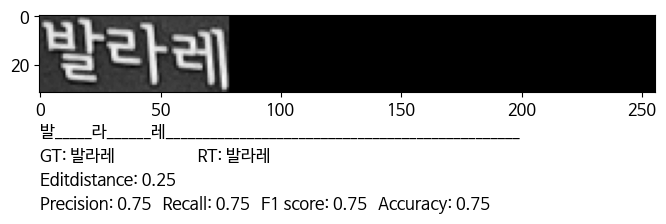

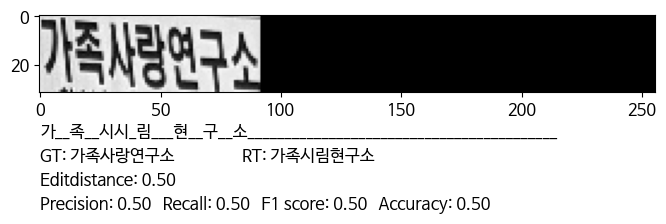

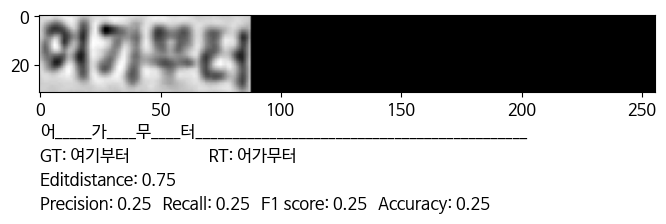

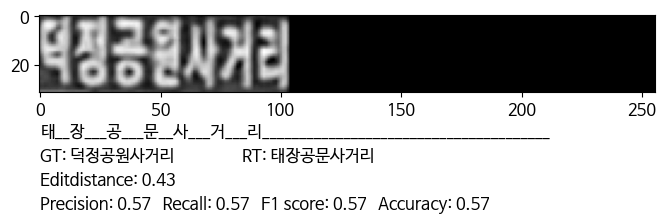

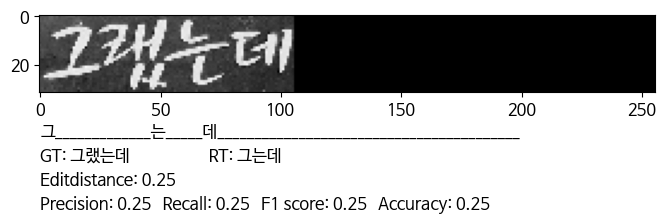

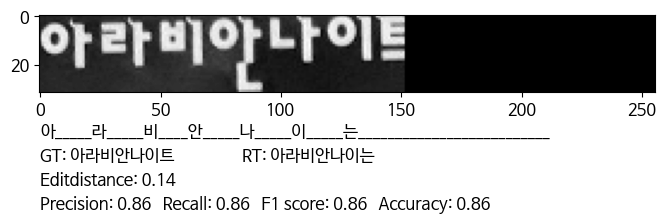

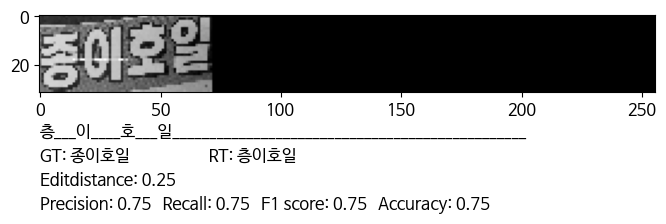

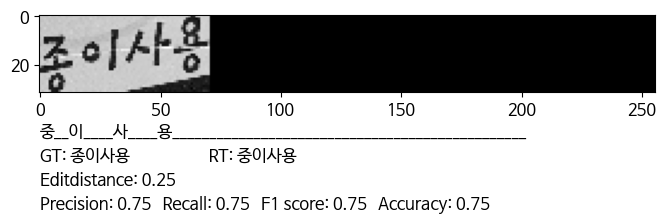

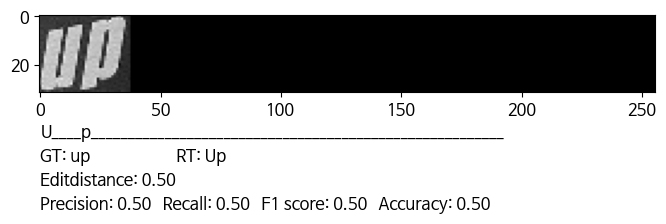

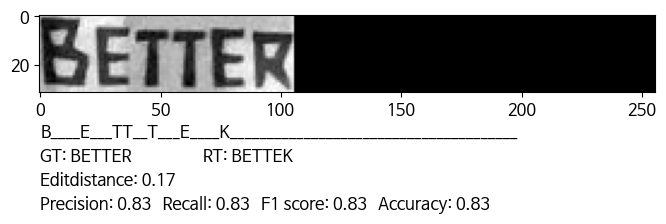

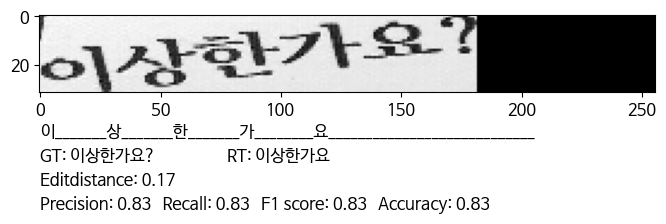

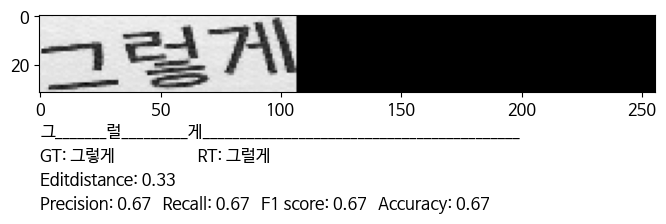

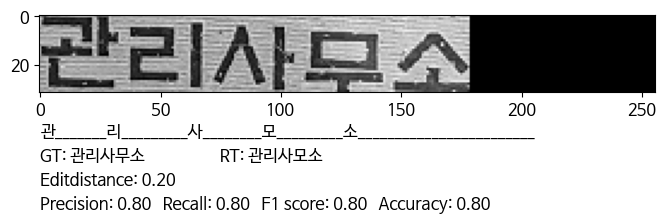

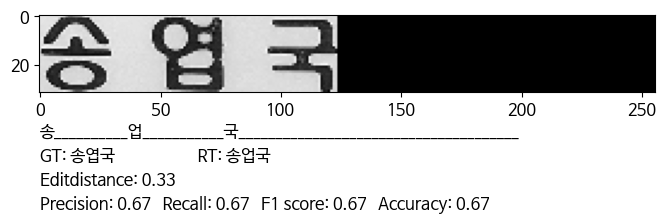

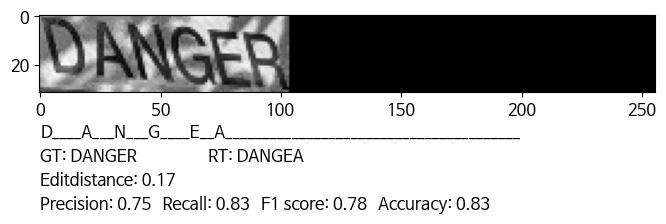

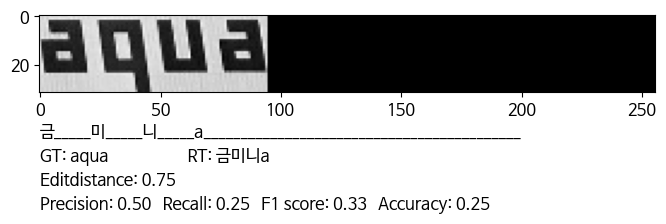

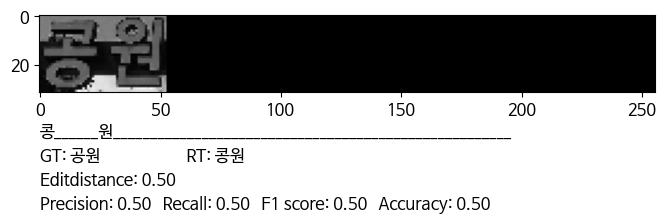

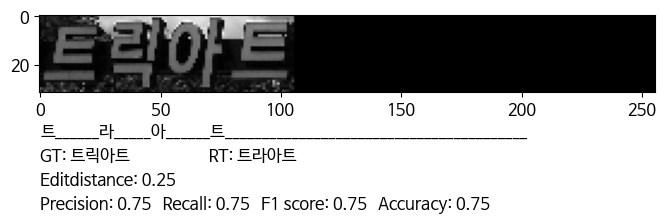

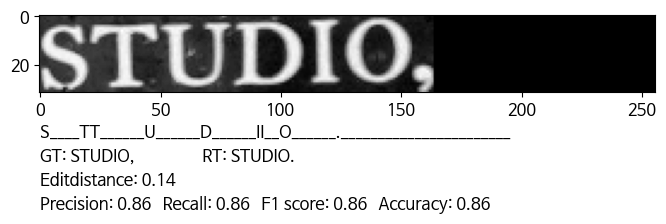

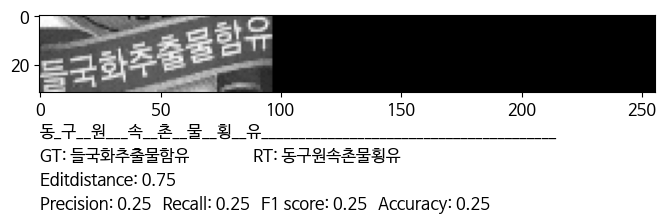

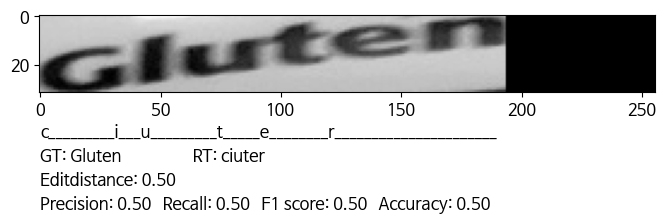

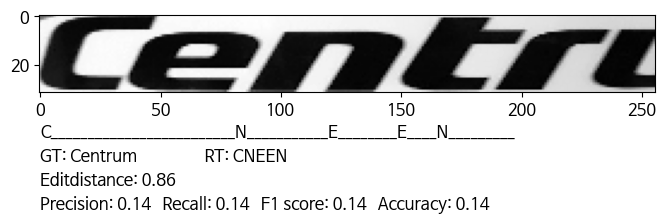

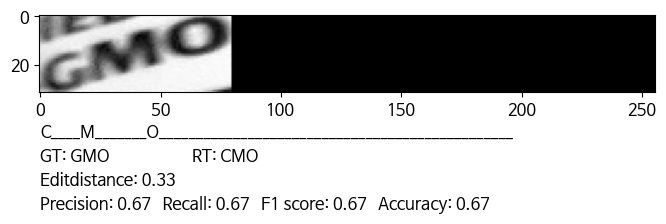

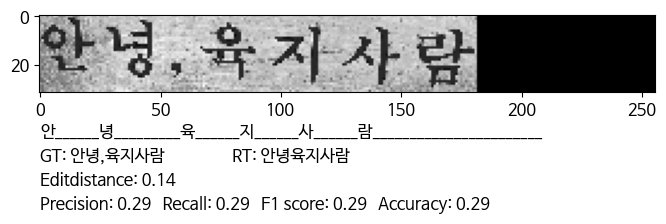

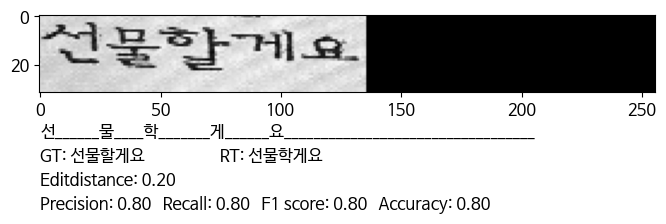

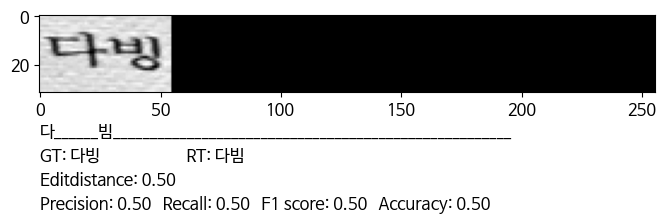

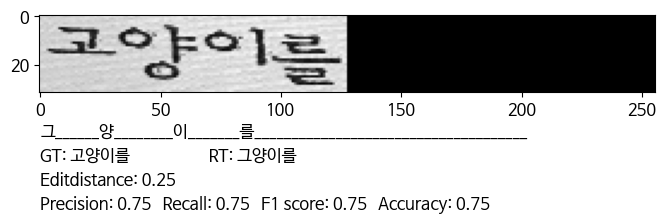

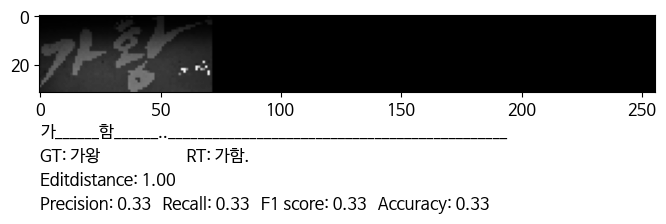

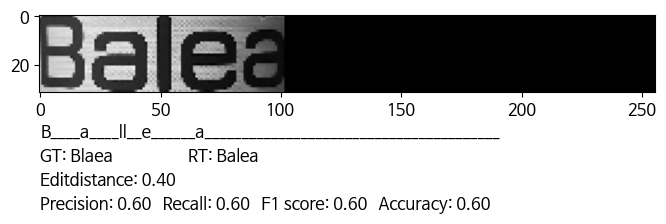

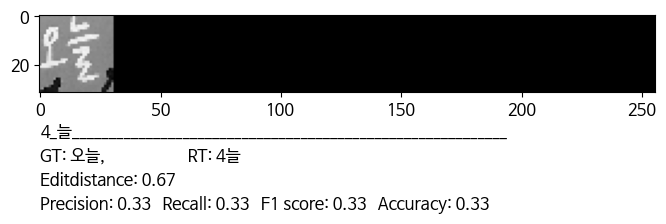

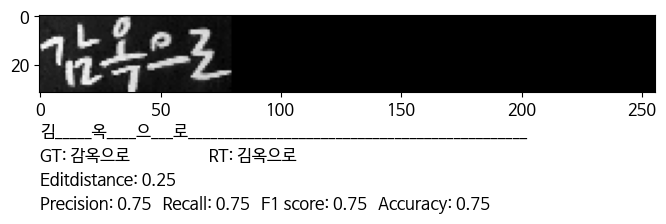

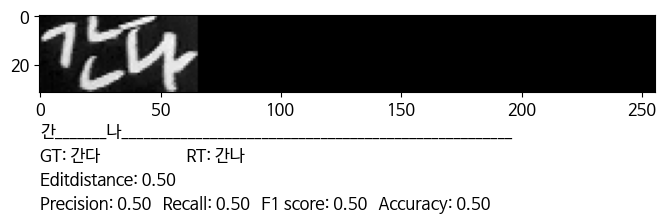

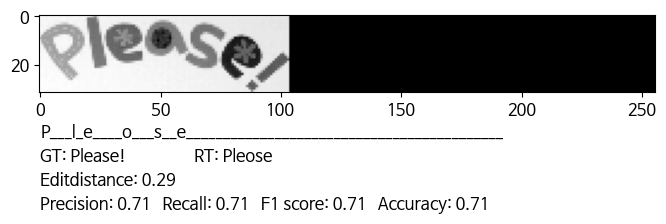

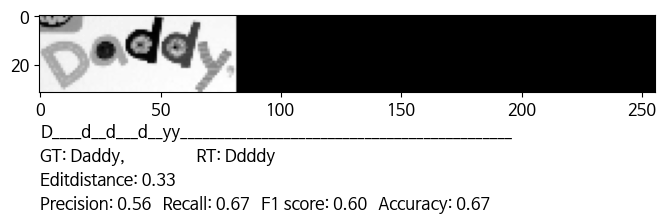

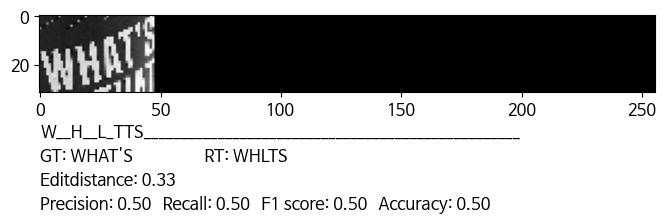

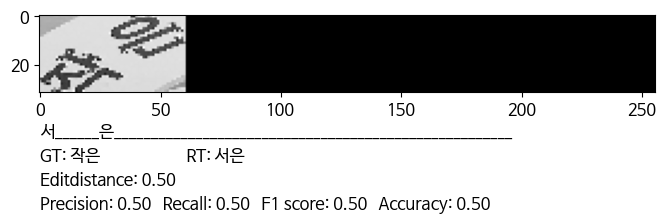

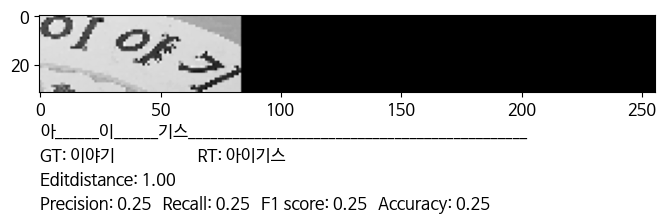

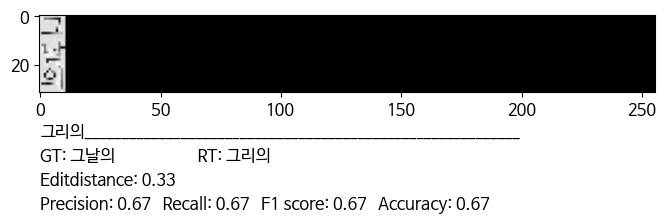

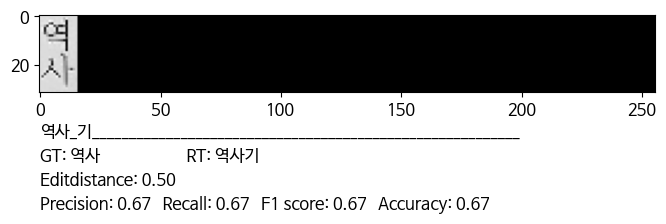

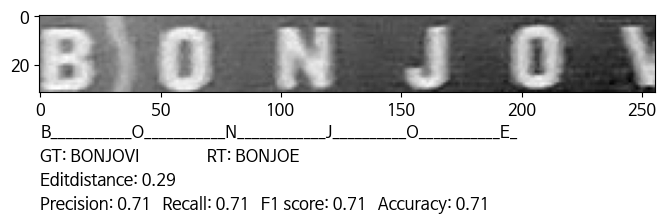

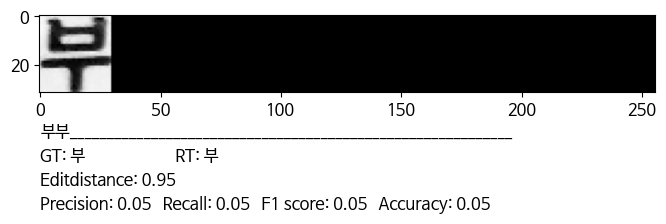

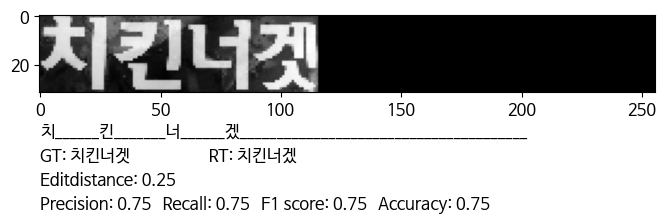

In [14]:
show_test_result(indices)

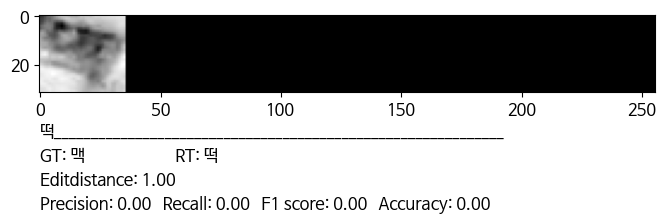

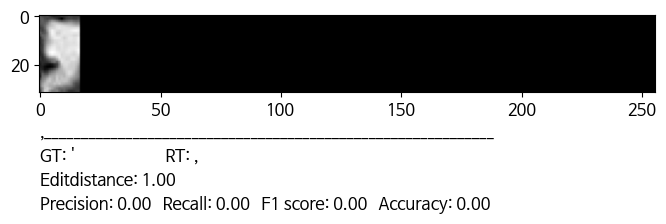

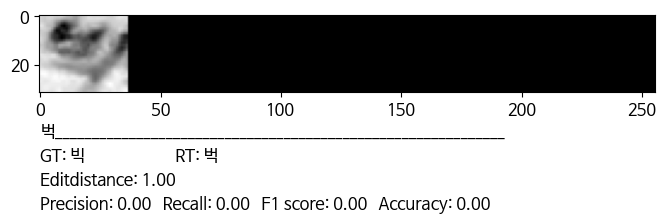

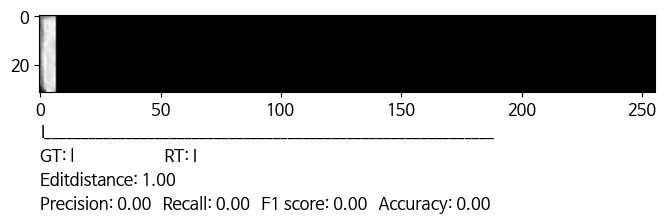

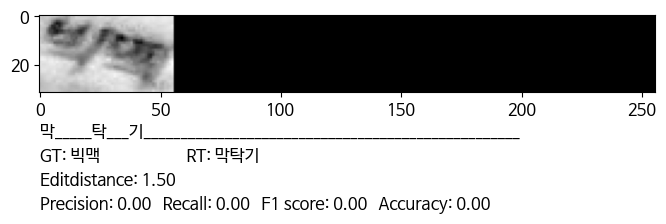

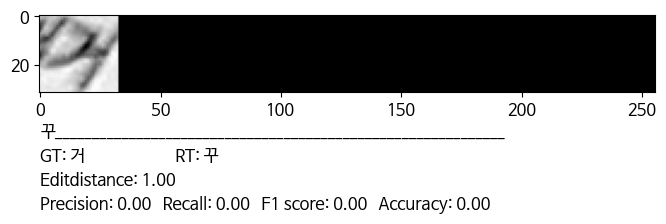

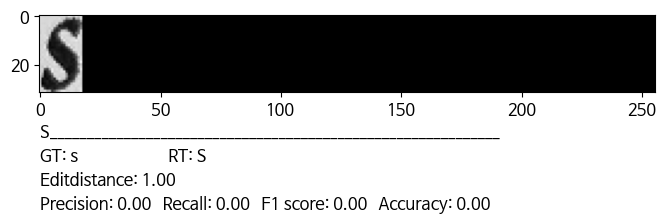

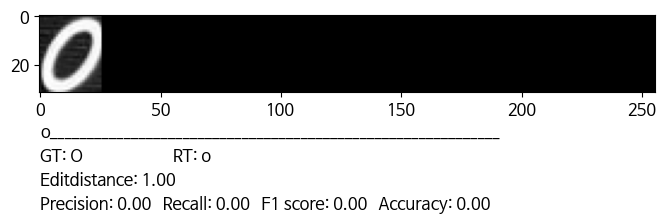

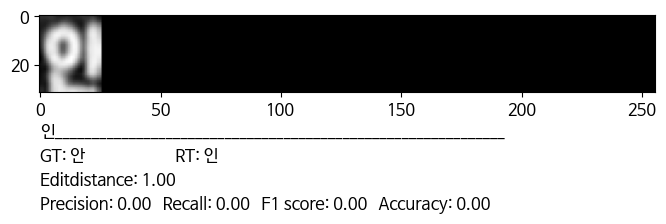

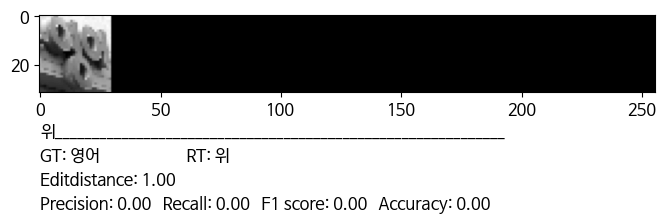

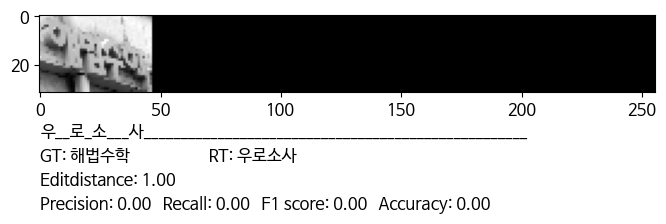

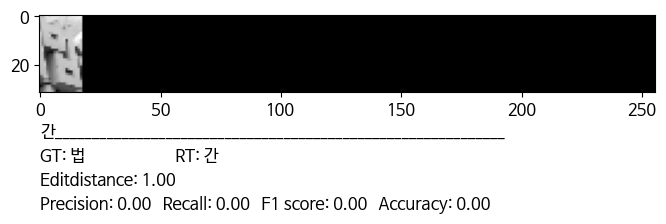

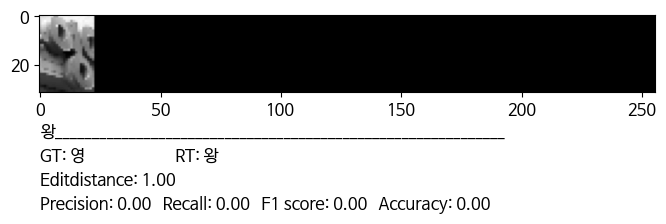

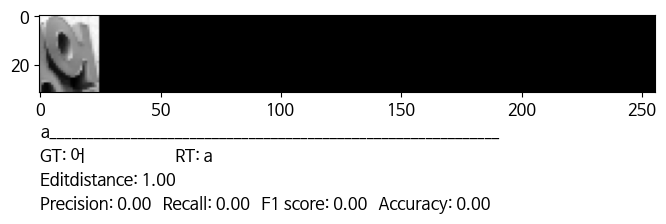

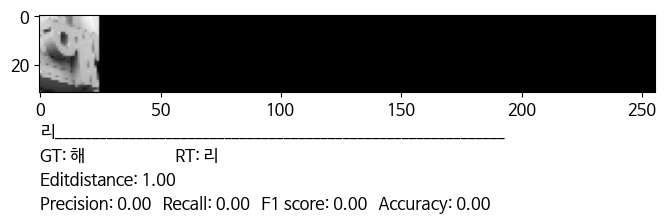

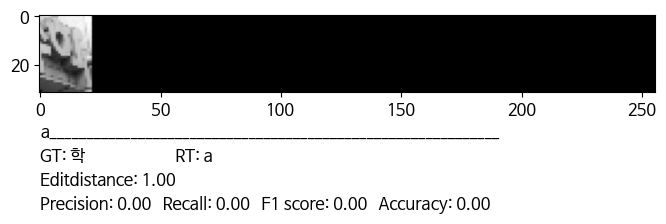

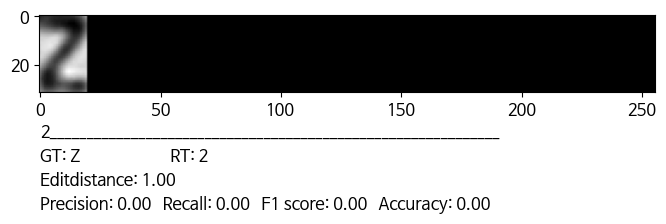

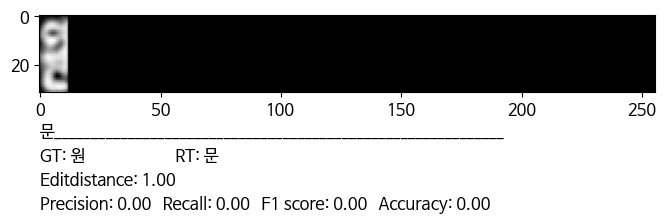

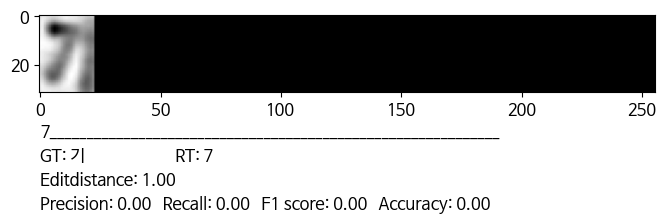

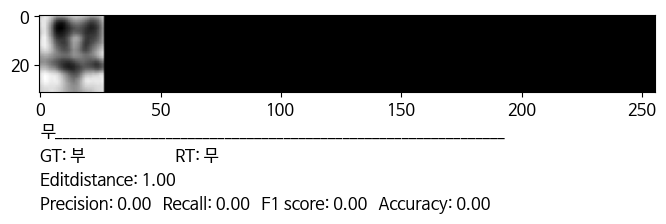

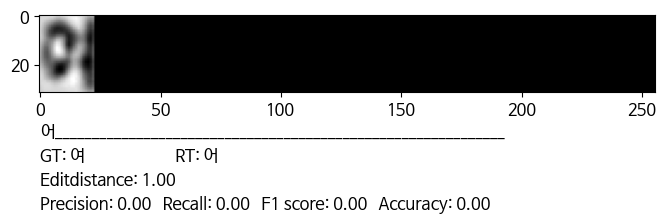

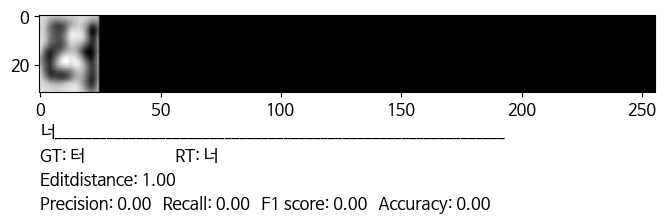

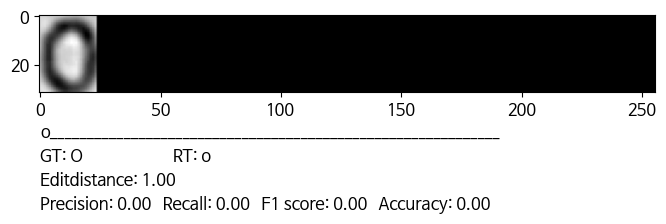

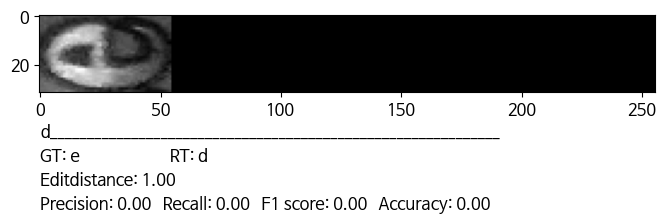

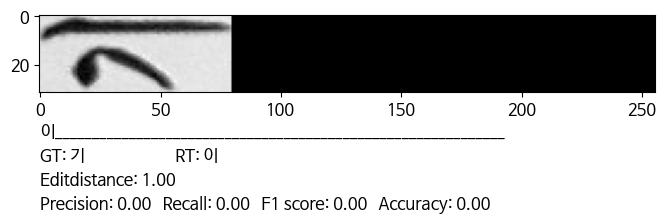

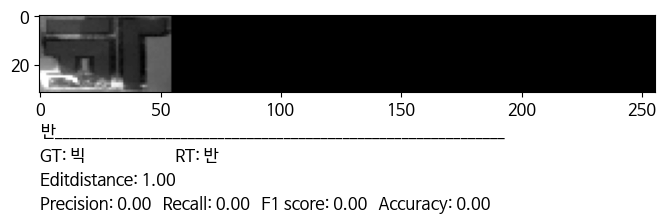

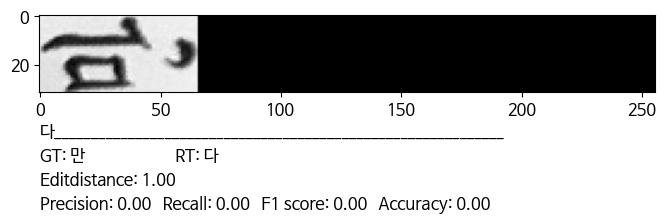

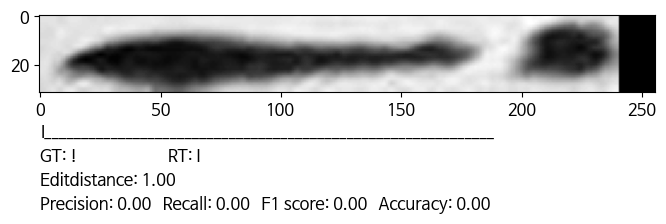

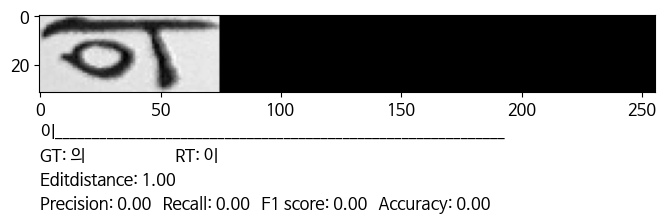

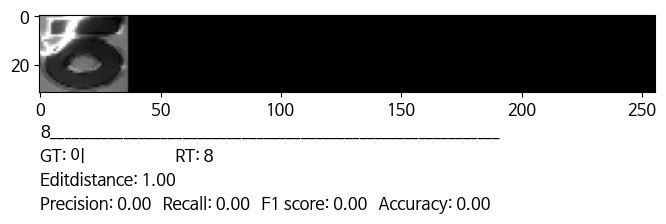

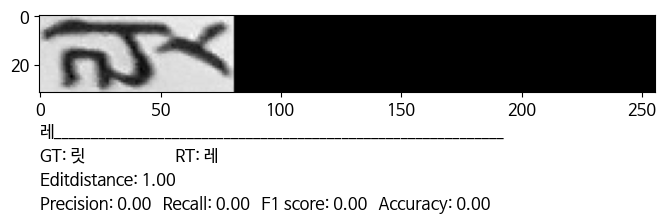

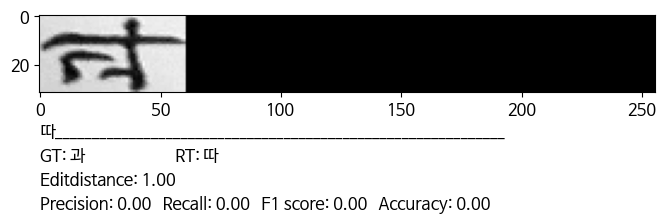

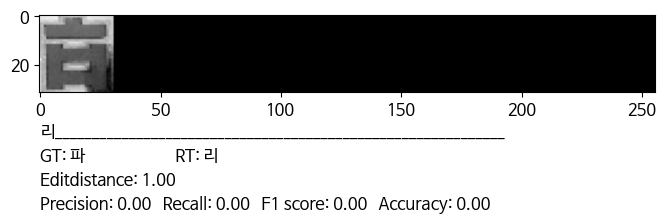

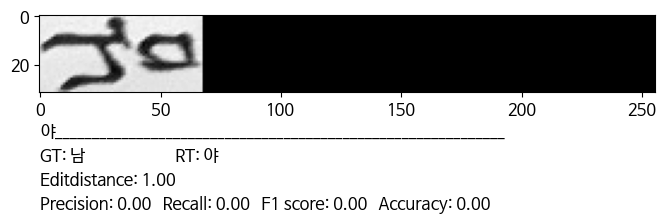

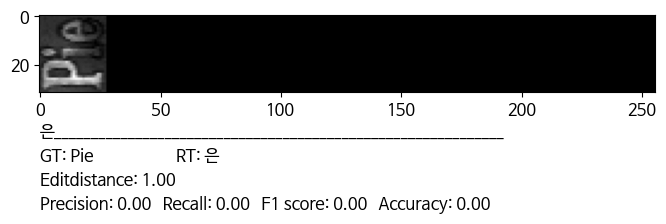

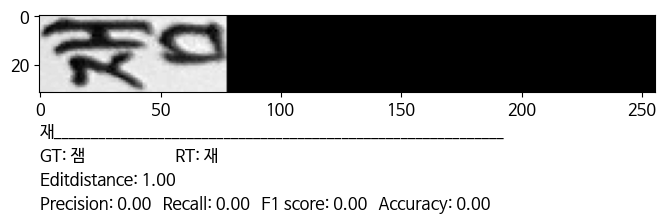

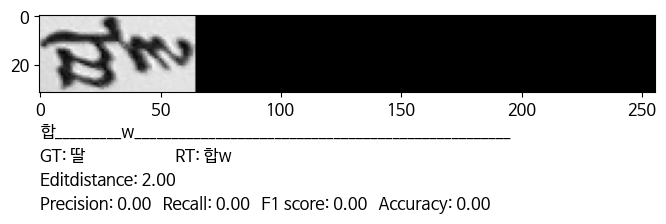

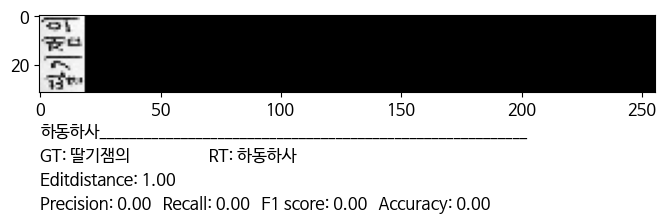

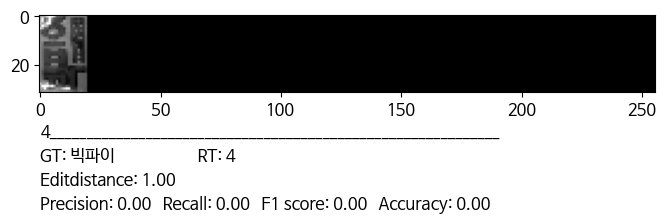

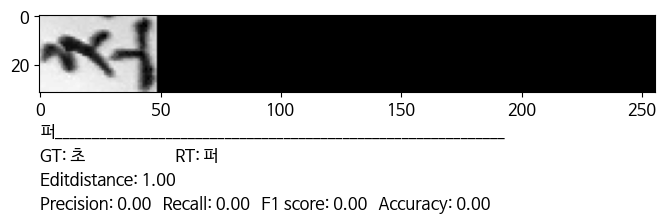

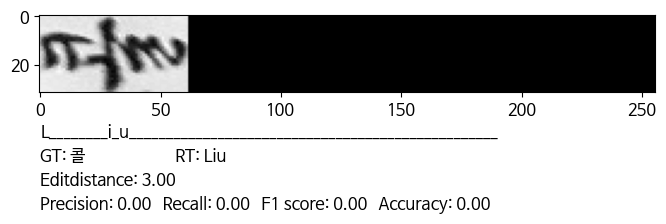

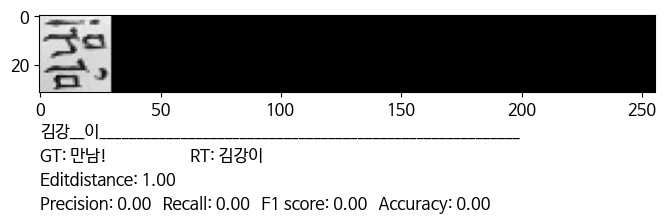

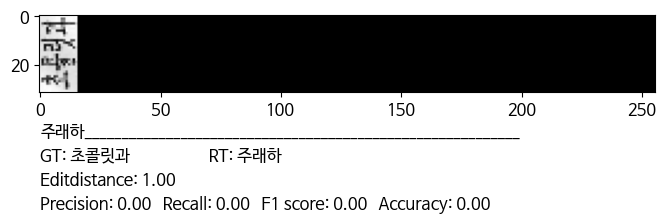

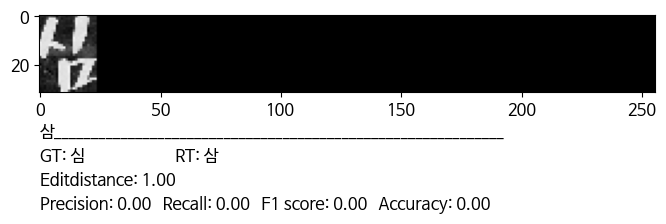

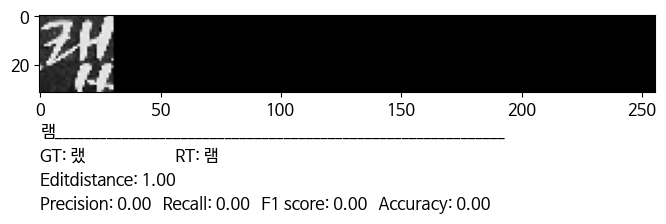

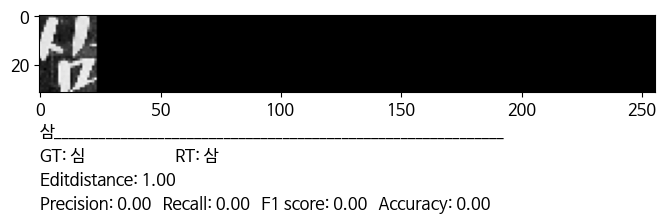

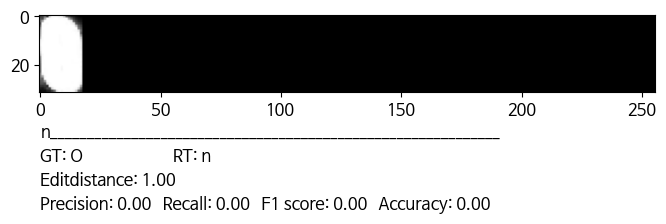

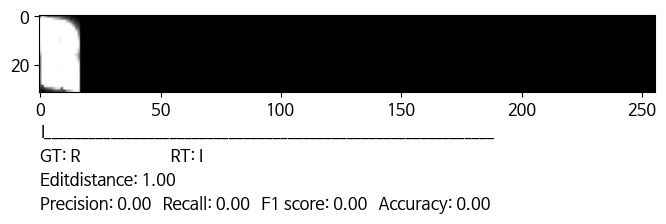

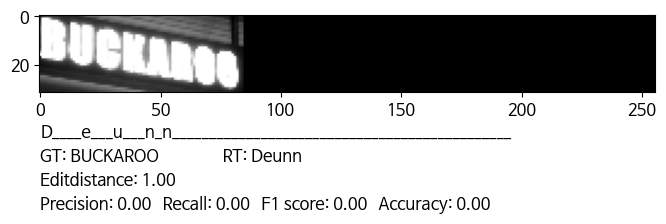

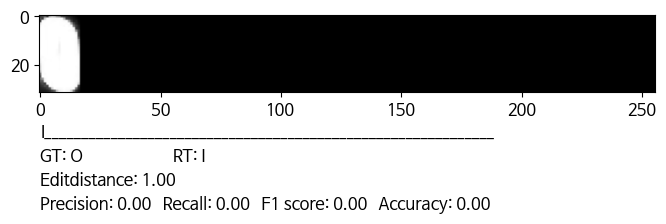

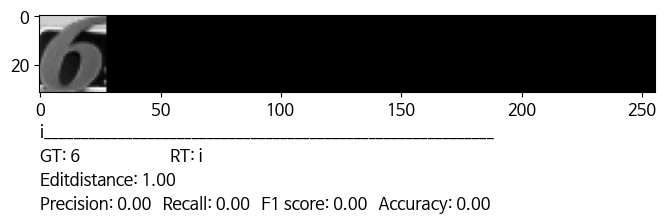

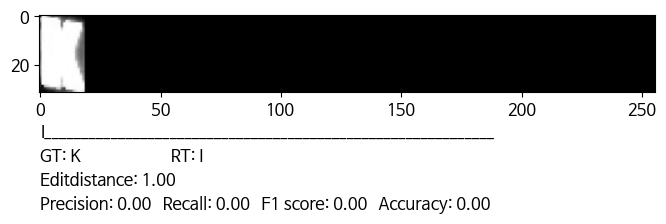

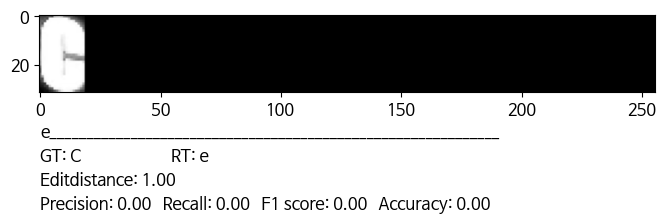

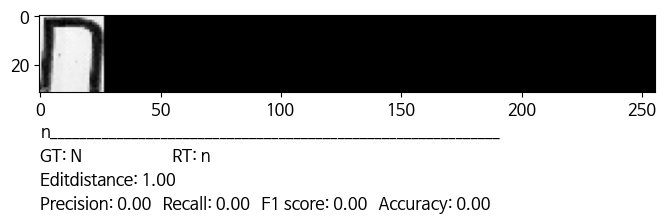

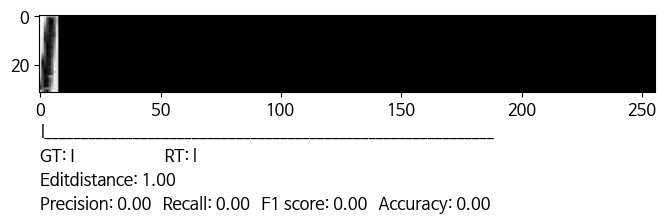

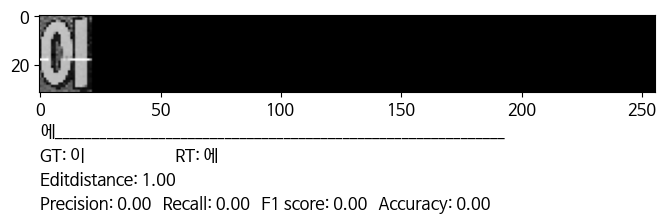

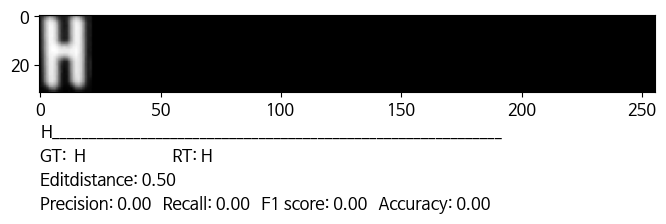

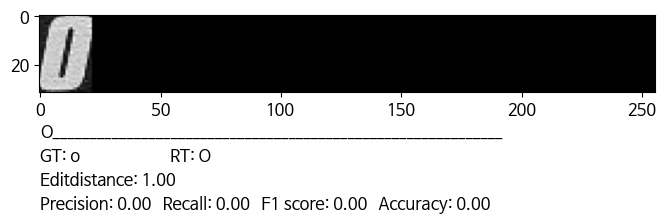

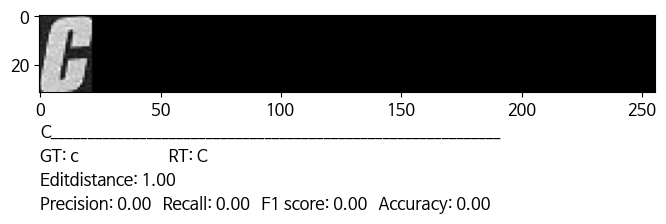

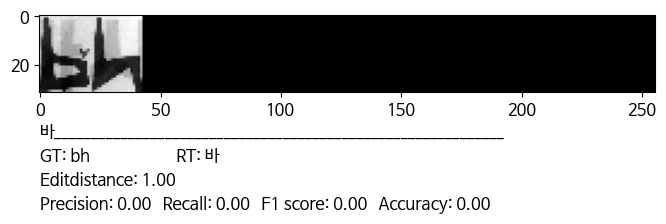

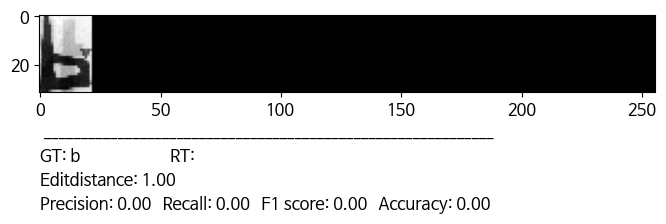

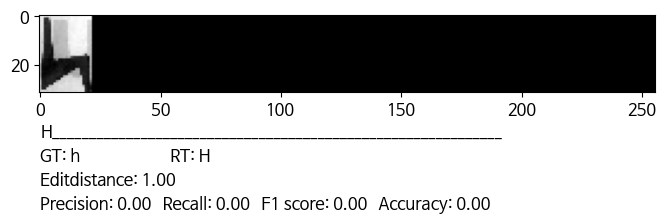

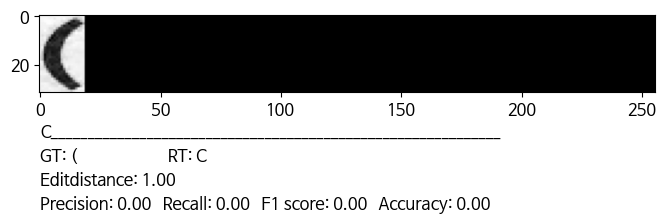

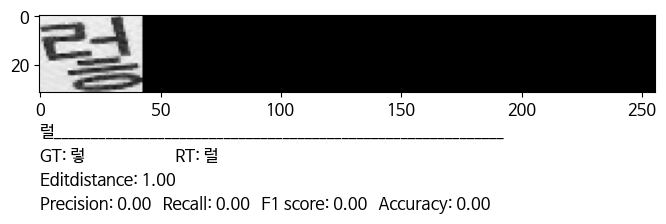

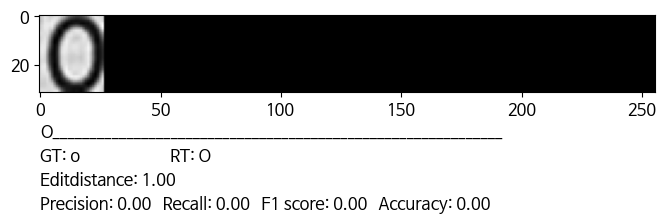

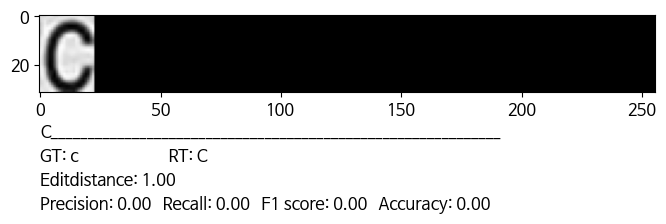

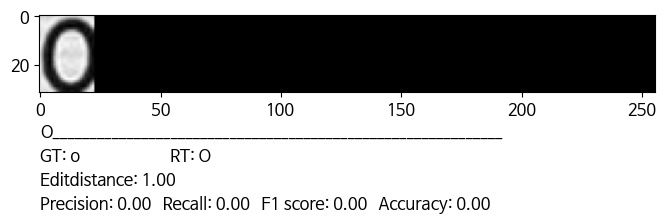

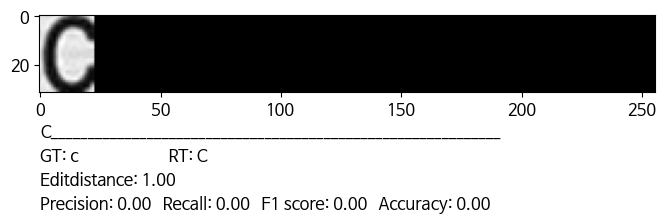

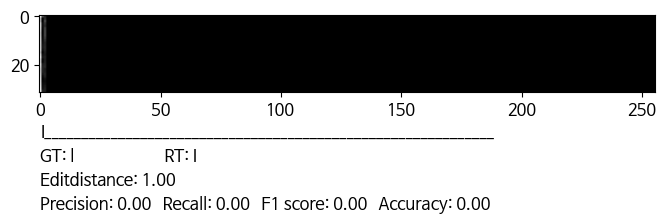

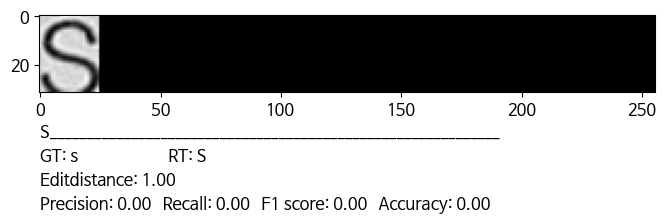

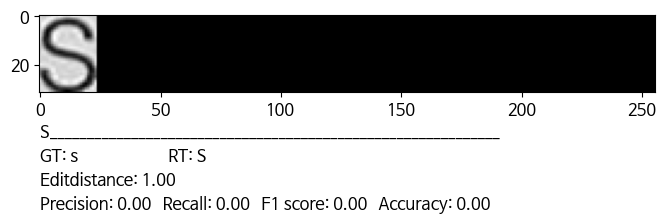

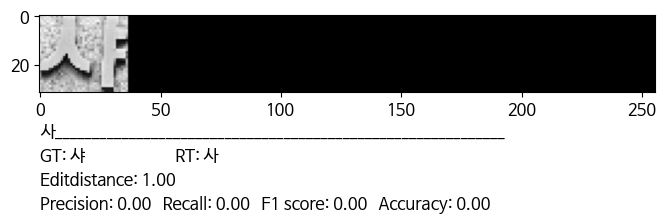

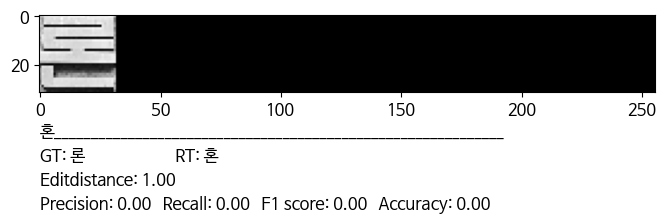

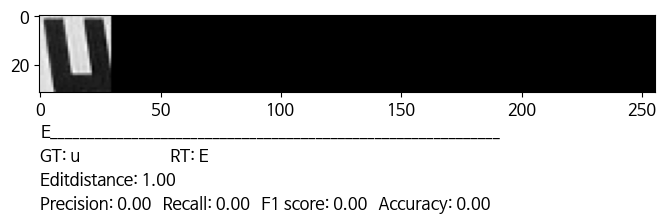

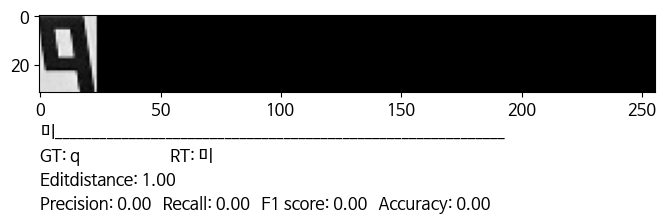

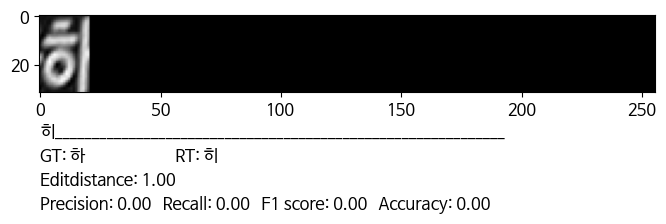

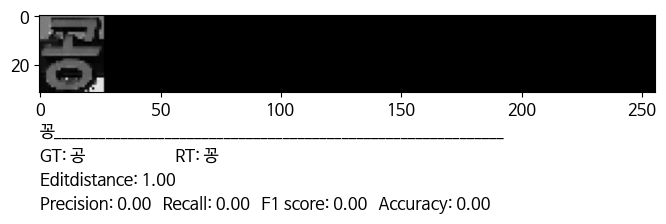

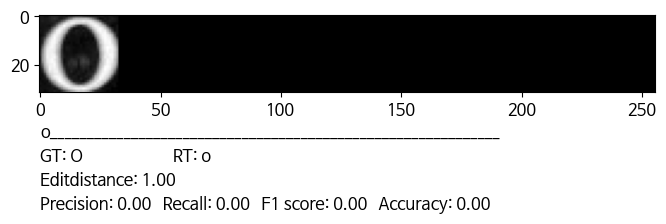

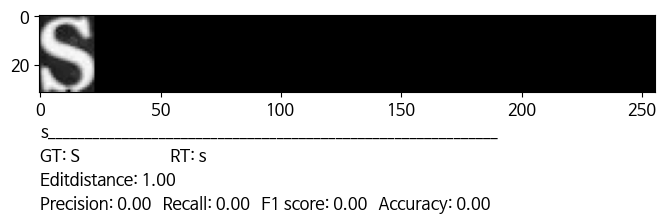

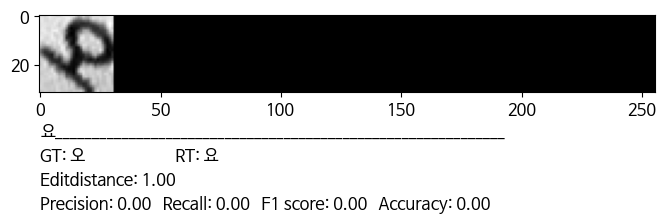

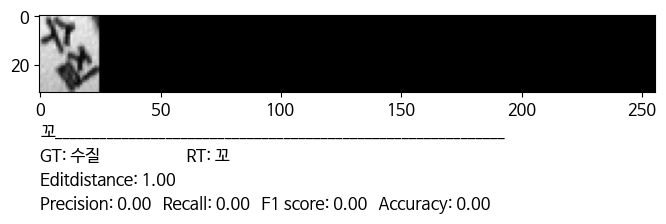

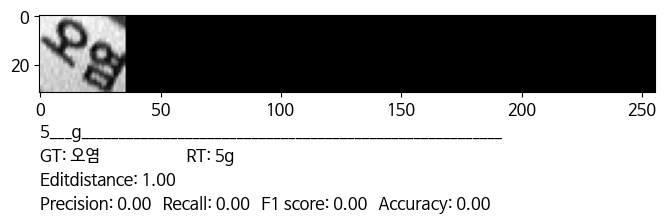

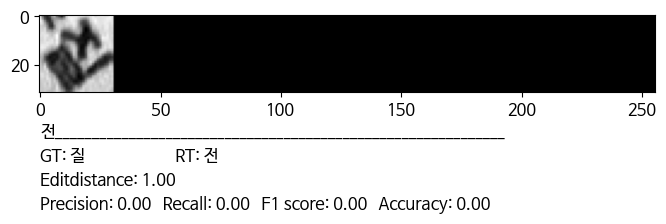

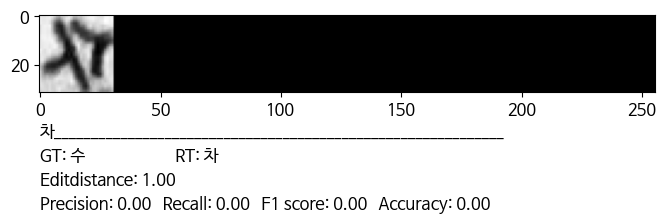

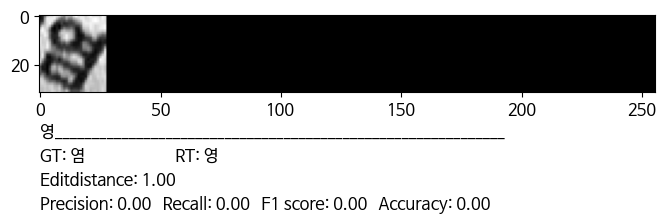

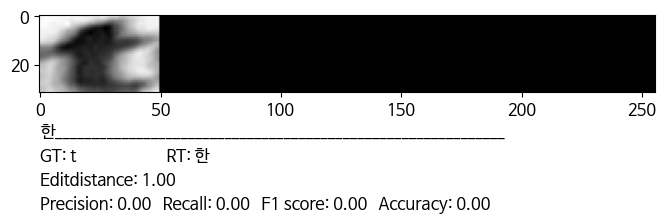

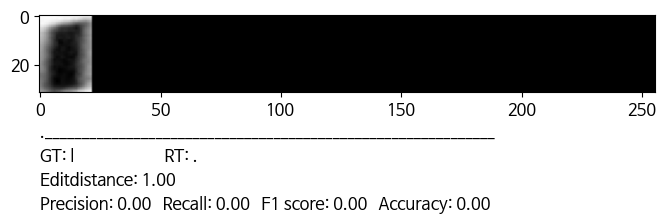

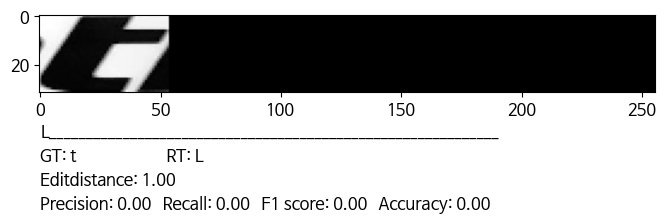

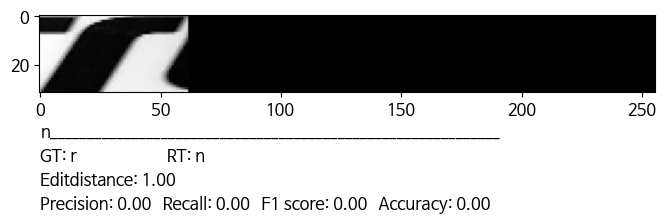

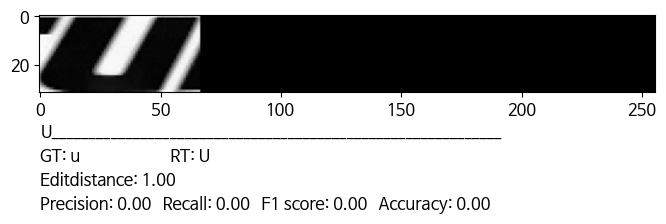

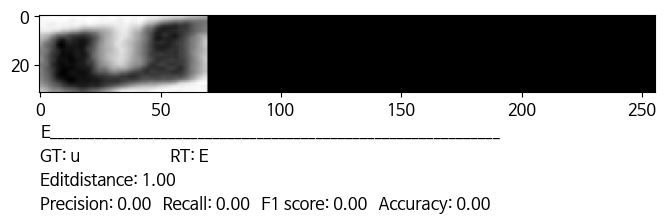

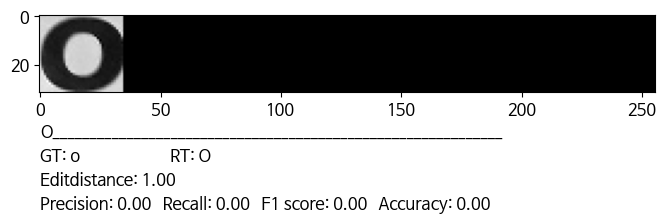

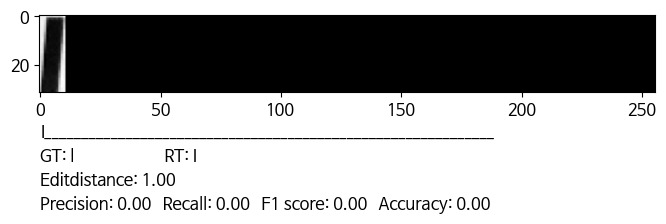

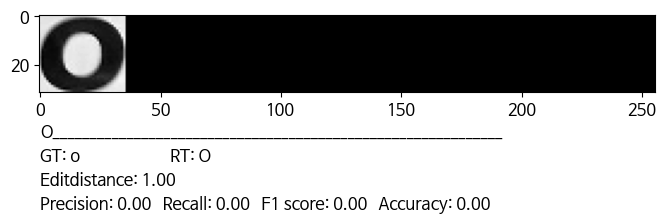

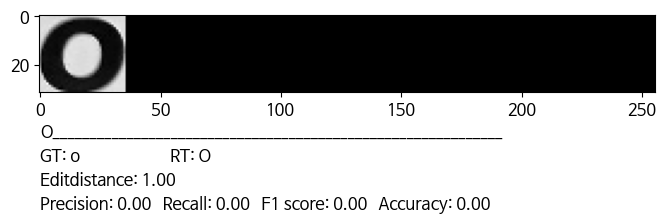

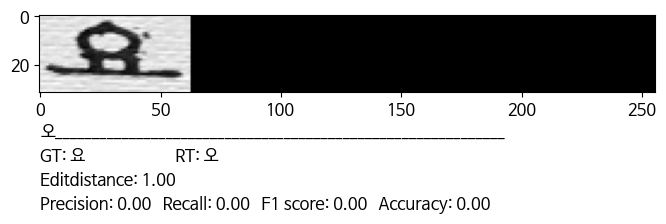

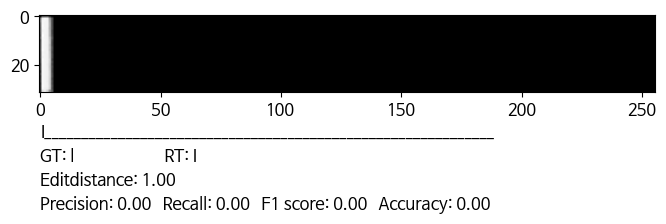

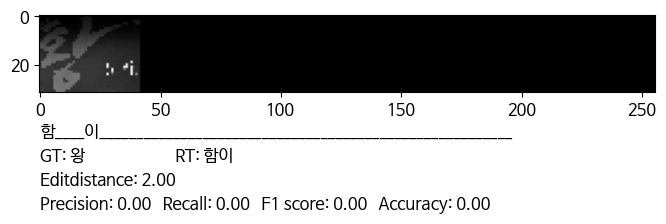

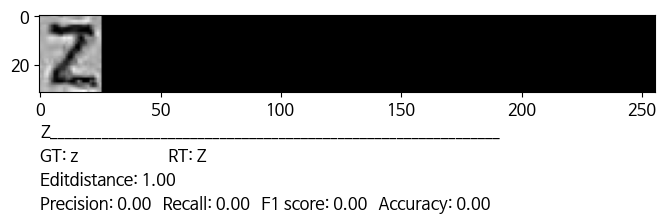

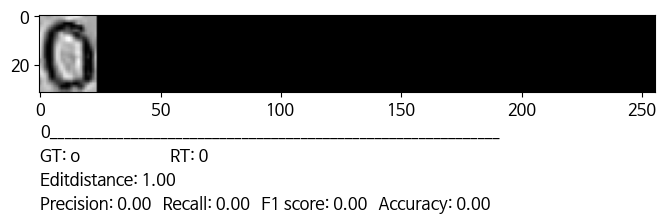

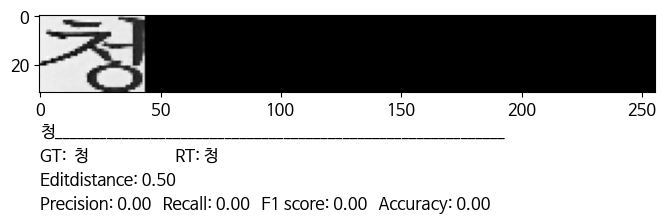

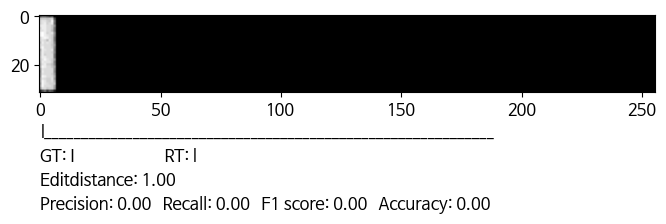

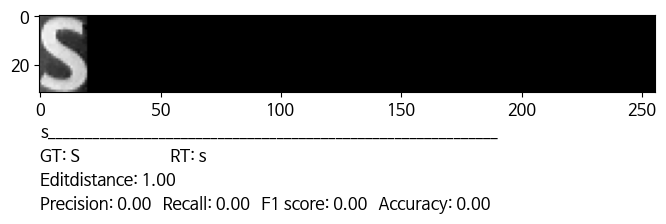

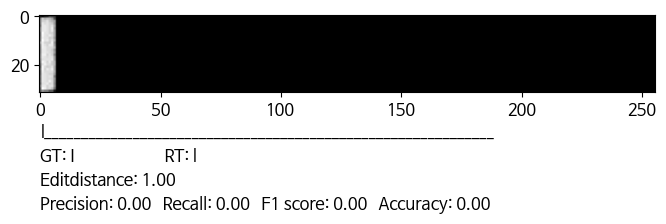

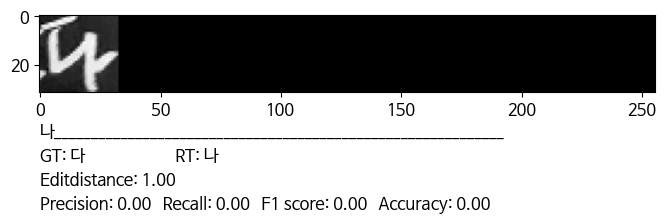

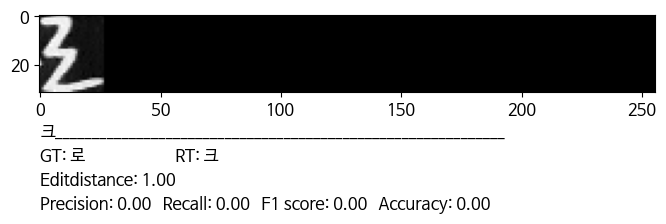

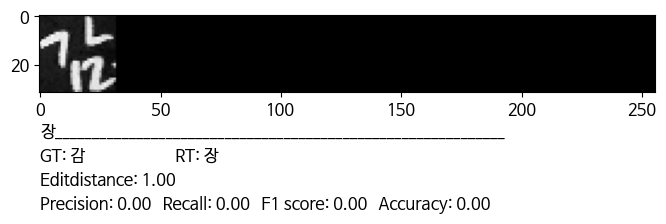

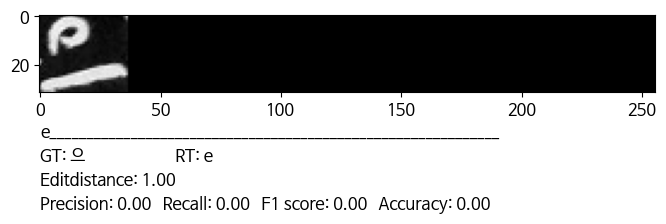

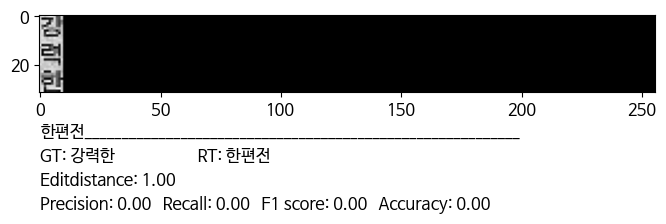

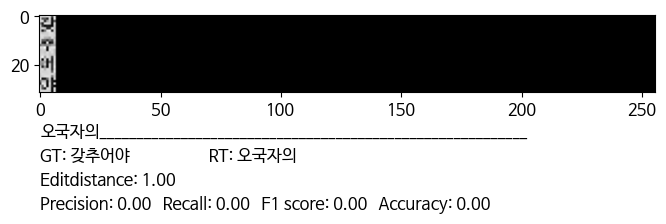

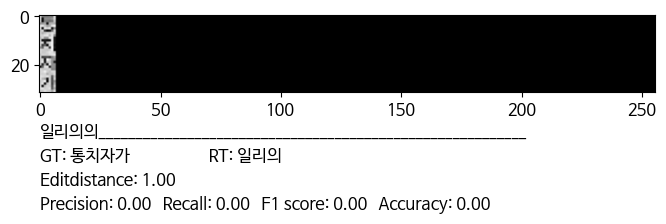

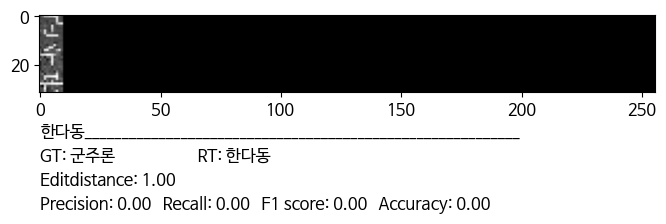

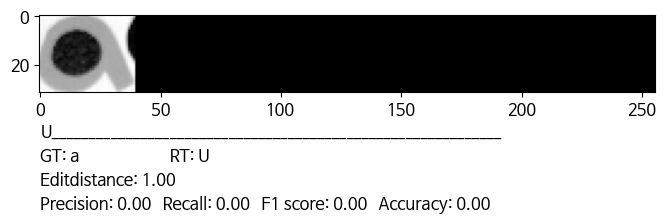

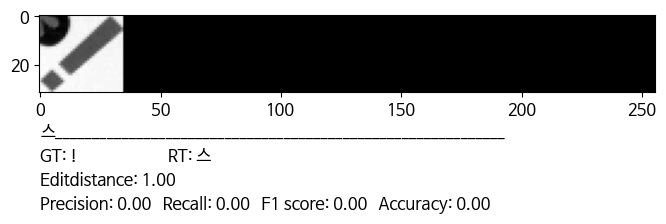

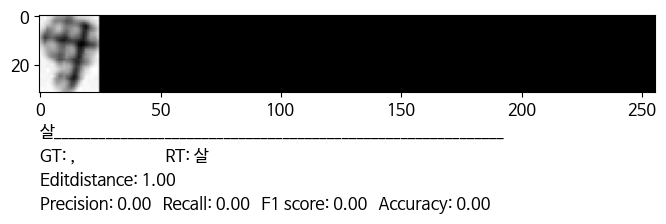

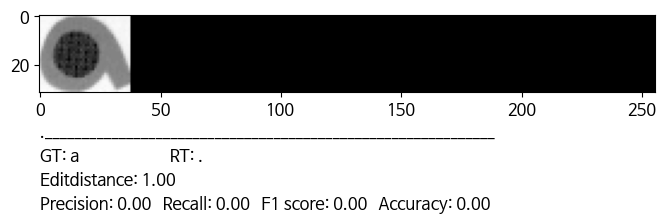

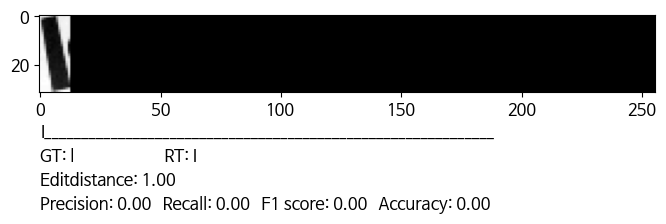

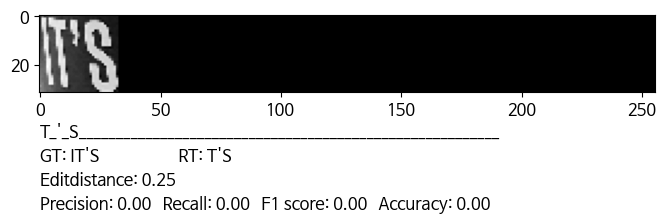

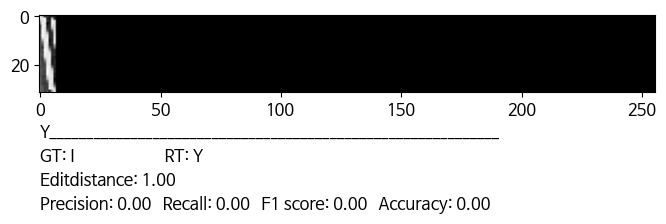

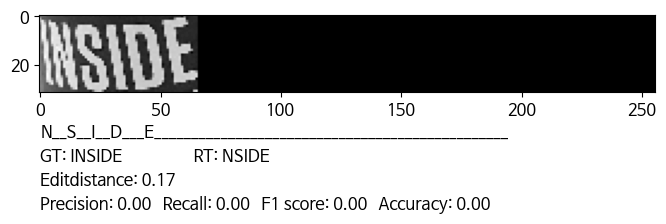

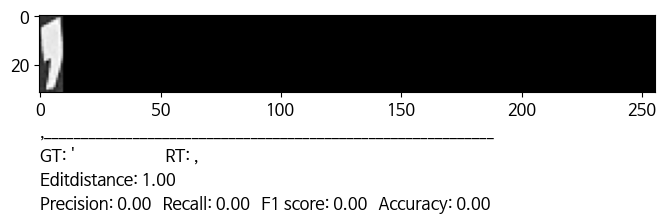

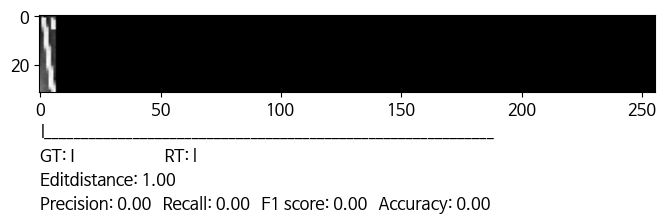

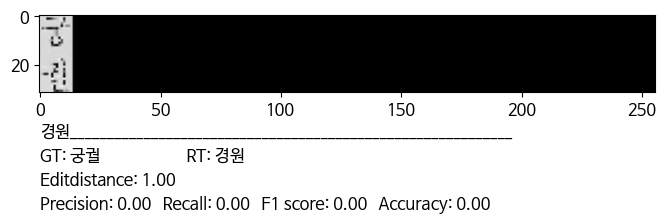

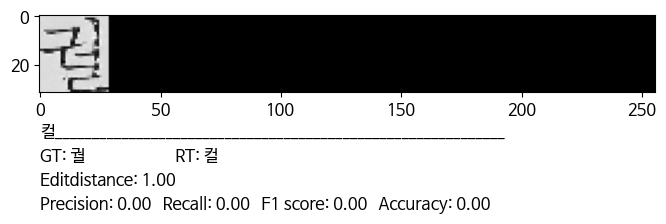

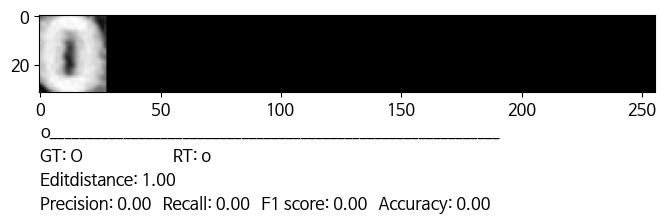

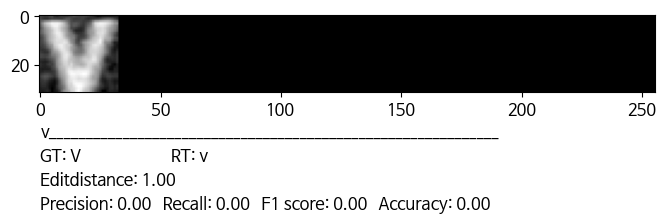

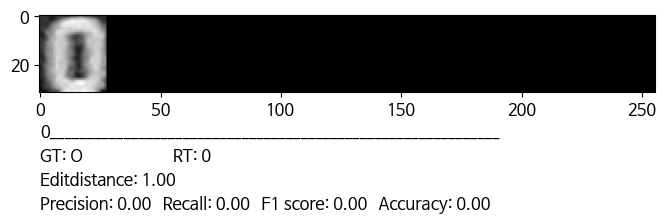

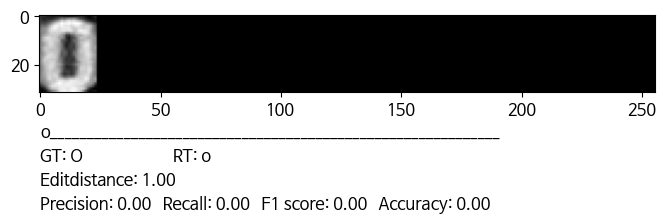

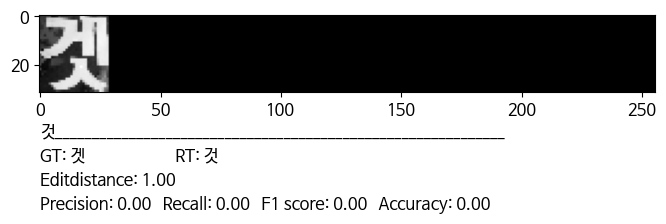

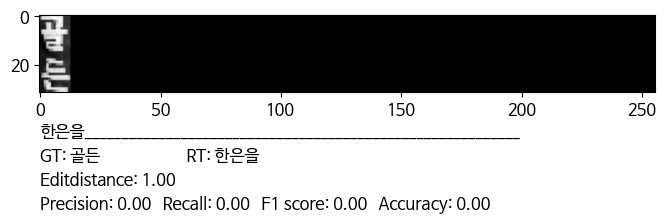

In [15]:
show_test_result(zero_indices)